## Necessary Imports

In [1]:
import os
import glob

import numpy as np
import torch

from scipy.ndimage import affine_transform

In [25]:
import cv2
from PIL import Image

## Visualizing

### Helpers From Log_Images class

In [33]:
class Log_Images:
    def __init__(
        self,
        # fabric: L.Fabric,
        config,
        writer=None,
    ):
        self.wandb_on = config.wandb_on
        self.pretrained = config.pretrained
        self.model_name = config.model_name
        self.nr_of_classes = config.nr_of_classes
        self.writer = writer
        if self.model_name == 'simple_unet':
            self.image_shape = (160,192)
        else:
            self.image_shape = (162,194)

        # color map to get always the same colors for classes
        if config.nr_of_classes in [2,7,51,107]: # freesurfer colors available
            colors = self.__rgb_map_for_data(config.nr_of_classes)
        else:
            colors = plt.cm.hsv(np.linspace(0, 1, config.nr_of_classes))
            colors = colors[:,:-1] * 255
        self.color_range = np.zeros((256,3))
        self.color_range[:colors.shape[0],:] = colors

        # load always the same image from validation set
        image_file = "pac_36_orig.nii.gz"
        mask_file = "pac_36_aseg.nii.gz"
        file_path = "/om2/user/matth406/nobrainer_data/data/SharedData/segmentation/freesurfer_asegs/"
        brain, mask, _ = load_brains(image_file, mask_file, file_path)
        mask = mapping(mask,nr_of_classes=self.nr_of_classes)

        self.brain_slices, self.mask_slices = [], []

        # randomly select slices in 3 directions
        self.slice_idx = [125, 150]
        normalization_constants = np.load(
            "/om2/user/matth406/nobrainer_data_norm/data_prepared_medium/normalization_constants.npy"
        )
        self.brain_slices = torch.empty((len(self.slice_idx) * 3, 1, self.image_shape[0], self.image_shape[1]))
        self.mask_slices = torch.empty((len(self.slice_idx) * 3, 1, self.image_shape[0], self.image_shape[1]),dtype=torch.long)
        i = 0
        self.logging_dict = {}
        for d in range(3):
            for slice_id in self.slice_idx:
                if d == 0:
                    brain_slice = crop(brain[slice_id, :, :], self.image_shape[0], self.image_shape[1])
                    mask_slice = crop(mask[slice_id, :, :], self.image_shape[0], self.image_shape[1])
                if d == 1:
                    brain_slice = crop(brain[:, slice_id, :], self.image_shape[0], self.image_shape[1])
                    mask_slice = crop(mask[:, slice_id, :], self.image_shape[0], self.image_shape[1])
                if d == 2:
                    brain_slice = crop(brain[:, :, slice_id], self.image_shape[0], self.image_shape[1])
                    mask_slice = crop(mask[:, :, slice_id], self.image_shape[0], self.image_shape[1])

                self.logging_dict[f"Image d{d} c{slice_id}"] = self.__create_plot(
                    self.wandb_on, brain_slice, caption="Raw Image",#fig_path=f'/om2/user/sabeen/test_imgs/raw_d{d}_c{slice_id}_fs.png'
                )
                self.logging_dict[f"True Mask d{d} c{slice_id}"] = self.__create_plot(
                    self.wandb_on,
                    mask_slice,
                    caption="True Mask",
                    color_range=self.color_range,
                    # fig_path=f'/om2/user/sabeen/test_imgs/true_mask_d{d}_c{slice_id}_fs.png'
                )
                brain_slice = (
                    brain_slice - normalization_constants[0]
                ) / normalization_constants[1]
                brain_slice = torch.from_numpy(brain_slice).to(torch.float32)
                brain_slice = brain_slice[None, None]
                self.brain_slices[i] = brain_slice

                mask_slice = torch.tensor(mask_slice)[None, None].long()
                self.mask_slices[i] = mask_slice

                i += 1

        # send all slices to device
        if self.pretrained:
            self.brain_slices = self.brain_slices.repeat((1, 3, 1, 1))
        self.brain_slices = fabric.to_device(self.brain_slices)
        self.mask_slices = fabric.to_device(self.mask_slices)

    @torch.no_grad()
    def logging(self, model, epoch: int, commit: bool):
        model.eval()
        probs = model(self.brain_slices)
        probs = probs.argmax(1)
        probs = probs.cpu()
        model.train()

        i = 0
        logging_dict = {}
        for d in range(3):
            for slice_id in self.slice_idx:
                logging_dict[f"Predicted Mask d{d} c{slice_id}"] = self.__create_plot(
                    self.wandb_on,
                    probs[i].numpy(),
                    caption=f"Epoch {epoch}",
                    color_range=self.color_range,
                    # fig_path=f'/om2/user/sabeen/test_imgs/predicted_mask_d{d}_c{slice_id}_fs.png'
                )
                i += 1
        current_logging_dict = self.logging_dict | logging_dict
        if self.wandb_on:
            wandb.log(current_logging_dict, commit=commit)
        
        if self.writer is not None:
            print('Logging images...')
            # only log raw image and true mask once
            if epoch == 1:
                for key, img in self.logging_dict.items():
                    img = np.array(img)
                    if len(img.shape) == 3:
                        self.writer.add_image(key, np.array(img), epoch, dataformats='HWC')
                    elif len(img.shape) == 2:
                        self.writer.add_image(key, np.array(img), epoch, dataformats='HW')
            
            # log predicted masks each time
            for key, img in logging_dict.items():
                img = np.array(img)
                if len(img.shape) == 3:
                    self.writer.add_image(key, np.array(img), epoch, dataformats='HWC')
                elif len(img.shape) == 2:
                    self.writer.add_image(key, np.array(img), epoch, dataformats='HW')
    

def __create_plot(
    wandb_on,
    image: np.array,
    caption: str,
    color_range = None,
    fig_path: str = None,
):
    if fig_path is not None and len(fig_path.split('.')) == 1:
        fig_path = fig_path + '.png'
        
    if color_range is not None:
        image = image.astype(np.uint8)
        channels = [cv2.LUT(image, color_range[:,i]) for i in range(3)]
        new_img = np.dstack(channels)
    
        if fig_path is not None:
            new_img_bgr = np.dstack([channels[2],channels[1],channels[0]])
            cv2.imwrite(fig_path,new_img_bgr)
        image = Image.fromarray(np.uint8(new_img))
    else:
        img_min = np.min(image)
        img_max = np.max(image)
        new_img = ((image - img_min) / (img_max - img_min) * 255).astype(np.uint8)
        if fig_path is not None:
            cv2.imwrite(fig_path,new_img)
        image = Image.fromarray(np.uint8(new_img))
    if wandb_on:
            image = wandb.Image(image, caption=caption)
    return image
    
def __extract_numbers_names_colors(FreeSurferColorLUT=''):
    """
    Extract lists of numbers, names, and colors representing anatomical brain
    regions from FreeSurfer's FreeSurferColorLUT.txt lookup table file.

    Parameters
    ----------
    FreeSurferColorLUT : string
        full path to FreeSurferColorLUT.txt file (else uses local Python file)

    Returns
    -------
    numbers : list of integers
        numbers representing anatomical labels from FreeSurferColorLUT.txt
    names : list of integers
        names for anatomical regions from FreeSurferColorLUT.txt
    colors : list of integers
        colors associated with anatomical labels from FreeSurferColorLUT.txt

    Examples
    --------
    >>> from mindboggle.mio.labels import extract_numbers_names_colors # doctest: +SKIP
    >>> ennc = extract_numbers_names_colors # doctest: +SKIP
    >>> en1,en2,ec = ennc('/Applications/freesurfer/FreeSurferColorLUT.txt') # doctest: +SKIP

    """
    import os
    from io import open

    # from ext.mindboggle.FreeSurferColorLUT import lut_text

    def is_number(s):
        try:
            int(s)
            return True
        except ValueError:
            return False

    # if os.environ['FREESURFER_HOME']:
    #     FreeSurferColorLUT = os.path.join(
    #              os.environ['FREESURFER_HOME'], 'FreeSurferColorLUT.txt')

    if FreeSurferColorLUT and os.path.exists(FreeSurferColorLUT):
        f = open(FreeSurferColorLUT, 'r')
        lines = f.readlines()
    # else:
    #     lut = lut_text()
    #     lines = lut.split('\n')

    numbers = []
    names = []
    colors = []
    for line in lines:
        strings = line.split()
        if strings and is_number(strings[0]):
            numbers.append(int(strings[0]))
            names.append(strings[1])
            colors.append([int(strings[2]), int(strings[3]),
                        int(strings[4])])

    return numbers, names, colors

def __rgb_map_for_data(nr_of_classes):
    _, fs_names, fs_colors = __extract_numbers_names_colors(
        "/om2/user/sabeen/freesurfer/distribution/FreeSurferColorLUT.txt"
    )

    with open("/om2/user/sabeen/readme", "r") as f:
        voxmorph_label_index = f.read().splitlines()

    # get the last 24 lines of the readme file (format--> id: name)
    if nr_of_classes == 51:
        voxmorph_label_index = [
            item.strip().split(":") for item in voxmorph_label_index[200:251] if item != ""
        ] # HACK
    elif nr_of_classes == 107:
        voxmorph_label_index = [
            item.strip().split(":") for item in voxmorph_label_index[91:198] if item != ""
        ] # HACK
    elif nr_of_classes == 7:
        voxmorph_label_index = [
            item.strip().split(":") for item in voxmorph_label_index[253:260] if item != ""
        ] # HACK
    elif nr_of_classes == 2:
        voxmorph_label_index = [
            item.strip().split(":") for item in voxmorph_label_index[262:264] if item != ""
        ] # HACK
    else:
        raise Exception(f'coloring for nr_of_classes = {nr_of_classes} not found')
    
    voxmorph_label_index = [
        [int(item[0]), item[1].strip()] for item in voxmorph_label_index
    ]
    voxmorph_label_index_dict = dict(voxmorph_label_index)
    my_colors = [
        fs_colors[fs_names.index(item)] for item in voxmorph_label_index_dict.values()
    ]

    return np.array(my_colors)

In [126]:
data_dir = '/om2/user/sabeen/nobrainer_data_norm/new_small_no_aug_51'
aug_dir = '/om2/user/sabeen/nobrainer_data_norm/20240202_small_aug_51'
mode = 'validation'

In [127]:
images = sorted(glob.glob(f"{data_dir}/{mode}/brain*.npy"))
masks = sorted(glob.glob(f"{data_dir}/{mode}/mask*.npy"))
affines = sorted(glob.glob(f"{aug_dir}/{mode}/affine*.npy"))

In [128]:
len(images) == len(masks) == len(affines)

True

In [130]:
colors = __rgb_map_for_data(51)
color_range = np.zeros((256,3))
color_range[:colors.shape[0],:] = colors

In [131]:
idx = 100
image = np.load(images[idx])
mask = np.load(masks[idx])
affine = np.load(affines[idx])

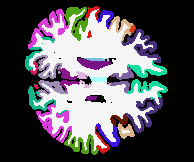

In [132]:
__create_plot(False,mask.squeeze().astype(np.uint8),'',color_range=color_range)

In [133]:
m = affine_transform(mask.squeeze().astype(np.uint8),affine,order=0)

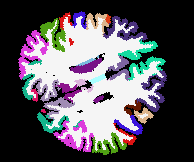

In [134]:
__create_plot(False,m,'',color_range=color_range)

In [142]:
torch.from_numpy(m).unsqueeze(dim=0).shape

(1, 162, 194)